In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Nov  9 15:52:12 2019

@author: JJB247
"""
"""
H added up path lengths along the boundaries
he used expaning sphere method
worked with computer science student who did fast march algorithm
One overall goal was to find the triple phase boundary density
"
The microstructural parameters such as volume fractions,
: DO NOT need particle diameter as its own quantity:, active/inactive triple 
phase boundary, tortuosity; were calculated
for the as-reduced cell and cells after operations.
"
"""
print('')

In [2]:
# Package Import
from threshold import threshold           # File I created to threshold images
from scipy.io import loadmat              # loads .mat file
from scipy import spatial                 # I'm not a math major but this works
from skimage import measure               # contains functions to find contours in 2d
import matplotlib.pyplot as plt           # plots data: includes plot & imshow
from mpl_toolkits import mplot3d          # supports 3d plotting
import pandas as pd                       # easy to use 2D data structure
import numpy as np                        # contains a variety of numerical
                                          # methods and data structures
from collections import Counter           # structure that counts occurences
from smt.sampling_methods import LHS      # latin hypercube sampling function
import pyDOE as pydoe                     # contains sampling methods
import os                                 # interacts with PATH to find files
import time                               # used for timer function
import tqdm                               # progress bar for iterables
import math                               # mathematical functions
import re                                 # regex bayBEEE

# define target folder
path = 'C:\\Users\\User\\Documents\\SOFC_Data_Science\\Data_OG'

In [3]:
# Load files from path 
# start timer
tic = time.time()
def load_files(path):
    """
    param: path: full path to the folder containing all data files
    return: loaded: dict of all files loaded, with keys equal to the
                    important part of the file names: format "PCT195-A2-Anode"
    return: filenames: list of full file paths for each file
    """
    filenames = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if '.mat' in file:
                filenames.append(os.path.join(r, file))

    print('files found: ')
    for f in filenames:
        print('.' + f[49:])

    # load all .mat files from target folder
    loaded={}
    for filename in filenames:
        fn = 'Amira_' + re.sub(r"[^\w\s\\:]", '_', filename)[50:]
        loaded.update({filename[50:-4] : loadmat(filename)[fn]})
    print(str(time.time()-tic) + ' seconds elapsed')
    return loaded, filenames
loaded,filenames = load_files(path)

files found: 
.\PCT195-A2-Anode.mat
.\PCt195-B1-Anode.mat
.\PCT195-B2-Anode-.mat
.\PCT209-1Khrs-anode.mat
.\PCT209-As-reduced-Anode.mat
0.5046617984771729 seconds elapsed


In [4]:
# extract one file
onefile = loaded[filenames[0][50:-4]]
#smallfile = onefile[0:57,0:302,0:7]

#for layernum in onefile.shape[2]:
for layerdepth in [0]:
    layerone = onefile[:,:,layerdepth] # extract first sheet of data from the matrix

In [5]:
# functions to numerically find edges
def numerical():
    xlimits = np.array([ [0, onefile.shape[0]-1], [0, onefile.shape[1]-1], [0, onefile.shape[2]-1]])
    sampling = LHS(xlimits=xlimits)

    samps = sampling(int(1e4)) # control number of points generated
    samps = np.round(samps,decimals=0).astype(int)

    def searchx(xin,yin,zin,matrix,direction):
        """
        param: xin: input x value for random point
        param: yin: input y value for random point
        param: zin: input z value for random point
        param: matrix: 3d input dataframe
        param: direction: must be 1 or -1: search east or west
        return: (xin,yin,zin): input coordinates
        return: (xin,yin+i,zin): output location of border
        return: (center,edgeval): change of phase
        """
        i = 0
        center = matrix[xin,yin,zin]
        edgeval = center
        # increment up until it finds northern border
        while edgeval == center and (xin+i > 0) and (xin+i < onefile.shape[0]):
            edgeval = matrix[xin+i,yin,zin]
            i+=direction

        return [(xin, yin, zin), (xin+i, yin, zin), (center,edgeval)]

    def searchy(xin,yin,zin,matrix,direction):
        """
        param: xin: input x value for random point
        param: yin: input y value for random point
        param: zin: input z value for random point
        param: matrix: 3d input dataframe
        param: direction: must be 1 or -1: search north or south
        return: (xin,yin,zin): input coordinates
        return: (xin,yin+i,zin): output location of border
        return: (center,edgeval): change of phase
        """
        i = 0
        center = matrix[xin,yin,zin]
        edgeval = center
        # increment up until it finds northern border
        while edgeval == center and (yin+i > 0) and (yin+i < onefile.shape[1]):
            edgeval = matrix[xin,yin+i,zin]
            i+=direction

        return [(xin, yin, zin), (xin, yin+i, zin), (center,edgeval)]

    def searchz(xin,yin,zin,matrix,direction):
        """
        param: xin: input x value for random point
        param: yin: input y value for random point
        param: zin: input z value for random point
        param: matrix: 3d input dataframe
        param: direction: must be 1 or -1: search in or out
        return: (xin,yin,zin): input coordinates
        return: (xin,yin,zin+i): output location of border
        return: (center,edgeval): change of phase
        """
        i = 0
        center = matrix[xin,yin,zin]
        edgeval = center
        # increment up until it finds northern border
        while edgeval == center and (zin+i > 0) and (zin+i < onefile.shape[2]):
            edgeval = matrix[xin,yin,zin+i]
            i+=direction

        return [(xin, yin, zin), (xin, yin, zin+i), (center,edgeval)]

    timer = time.time()
    borderdata = []
    for [xpos,ypos,zpos] in tqdm.tqdm(samps):
        # run through the search algoriths (up and down) for each dimension)
        # currently runs in O(n) time, at 2000 operations per second
        borderdata.append(searchx(xpos,ypos,zpos,onefile,direction =  1))
        borderdata.append(searchx(xpos,ypos,zpos,onefile,direction = -1))
        borderdata.append(searchy(xpos,ypos,zpos,onefile,direction =  1))
        borderdata.append(searchy(xpos,ypos,zpos,onefile,direction = -1))
        borderdata.append(searchz(xpos,ypos,zpos,onefile,direction =  1))
        borderdata.append(searchz(xpos,ypos,zpos,onefile,direction = -1))

    print('Time elapsed: ' + str(time.time()-timer) + ' seconds.')
    print(str(samps.shape[0]) + ' points scanned.')

    borders = [item[1] for item in borderdata] # just border locations
    ## if (item[2][0]!=item[2][1]) : add to line above to clean noise from intersecting edges
    sliced = [item for item in borders if item[2]==1] # just second slice
    # NOTE that where any dimension == 0 or max of that dimension, there will be a lot of noise
    # plot the first slice
    fig4 = plt.figure(figsize=(12,4))
    # note that 1 and 0 below should be switched for accurate dimension
    plt.plot([item[1] for item in sliced],
             [item[0] for item in sliced],
             marker=',',linestyle='')
    #plt.gca().invert_yaxis()

In [6]:
# find boundaries for this layer, and add them to a large list of points 
# (300ms/layer)
darkregions = measure.find_contours(layerone, 1)
whiteregions = measure.find_contours(layerone, 2)
filteredlayer = layerone.copy()
filteredlayer[filteredlayer == 3] = 1
greyregions = measure.find_contours(filteredlayer, 1)

# add all black outlines (red lines) to a single list
redlines = []
for bsublist in darkregions:
    # iterate through every subarray in the black outlines
    for point in bsublist:
        # iterate through every point in the sublist, adding the z coordinate
        ppt = point.tolist()
        #ppt.append(layerdepth)
        #ppt = np.array(ppt)
        #ppt = np.around(ppt)
        #ppt = ppt.tolist()
        redlines.append(ppt)
                
# add all white outlines (blue lines) to a single list
bluelines = []
for wsublist in whiteregions:
    # iterate through every subarray in the white outlines
    for point in wsublist:
        # iterate through every point in the sublist, adding the z coordinate
        ppt = point.tolist()
        #ppt.append(layerdepth)
        #ppt = np.array(ppt)
        #ppt = np.around(ppt)
        #ppt = ppt.tolist()
        bluelines.append(ppt)
        
# add all grey outlines (yellow lines) to a single list
yellowlines = []
for ysublist in greyregions:
    # iterate through every subarray in the white outlines
    for point in ysublist:
        # iterate through every point in the sublist, adding the z coordinate
        ppt = point.tolist()
        #ppt.append(layerdepth)
        #ppt = np.array(ppt)
        #ppt = np.around(ppt)
        #ppt = ppt.tolist()
        yellowlines.append(ppt)

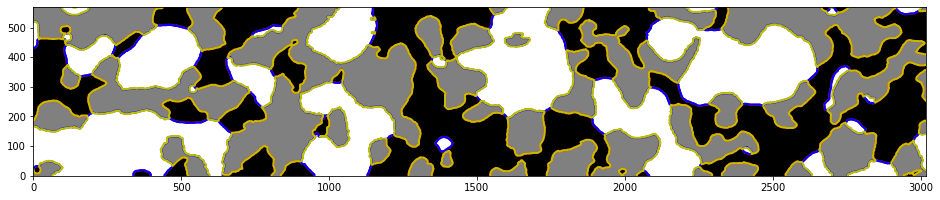

In [7]:
# function to plot image with all boundaries fully filled in (includes overlap)
def plotcontours(image,black,white,grey):
    """
    input: image: background image (entire array for current layer)
    input: black: contour of one colored region
    input: white: contour of one colored region
    input: grey: contour of one colored region
    outputs a graph of the array with borders marked.
    """
    fig, ax = plt.subplots(figsize=(16,6))
    ax.imshow(image, cmap=plt.cm.gray)
    for contour in black: # black (1) regions are outlined in red
        ax.plot(contour[:, 1], contour[:, 0], 'r', linewidth=2)
    for contour in white: # white (3) regions are outlined in blue
        ax.plot(contour[:, 1], contour[:, 0], 'b', linewidth=2)
    for contour in grey: # grey (2, assuming no filter) regions in yellow
        ax.plot(contour[:, 1], contour[:, 0], 'y', linewidth=2)

    # set up graph aesthetics
    ax.axis('image')
    ax.invert_yaxis()
    plt.show()

plotcontours(layerone,darkregions,whiteregions,greyregions)

In [8]:
# find all three-phase boundaries
intersects = []
# find the physical intersection of each set (only finds exact values)
for item in tqdm.tqdm(redlines): 
    if item in bluelines:
        if item in yellowlines:
            intersects.append(item)
                    

100%|████████████████████████████████████████████████████████████| 14764/14764 [00:04<00:00, 3076.37it/s]


In [19]:

def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    deltas = nodes - node
    dist_2 = np.einsum('ij,ij->i', deltas, deltas)
    return np.argmin(dist_2)
# find black-white boundaries
bw = []
for node in tqdm.tqdm(bluelines):
    bw.append(redlines[closest_node(node,redlines)])
# find white-grey boundaries    
wg = []
for node in tqdm.tqdm(bluelines):    
    wg.append(yellowlines[closest_node(node,yellowlines)])    
# find black-grey boundaries      
bg = []
for node in tqdm.tqdm(redlines):
    bg.append(yellowlines[closest_node(node,yellowlines)])

# function to clean duplicate values from list (creates new list)
def clean_dupes(inlist):
    """
    input: inlist: the list to be cleaned
    output: outlist: all unique values (of any type) in inlist
    """
    outlist = []
    [outlist.append(x) for x in inlist if x not in outlist]
    return outlist

# clean duplicates (to reduce computational intensity of future processing)
bwu = clean_dupes(bw) 
wgu = clean_dupes(wg) 
bgu = clean_dupes(bg) 
print('')

100%|█████████████████████████████████████████████████████████████| 14764/14764 [01:20<00:00, 183.05it/s]


In [22]:
# now, find the three phase boundaries
intersects = []
for node in tqdm.tqdm(bwu):
    intersects.append(wgu[closest_node(node,wgu)])
    
intersects = clean_dupes(intersects)

100%|███████████████████████████████████████████████████████████████| 3624/3624 [00:08<00:00, 439.30it/s]


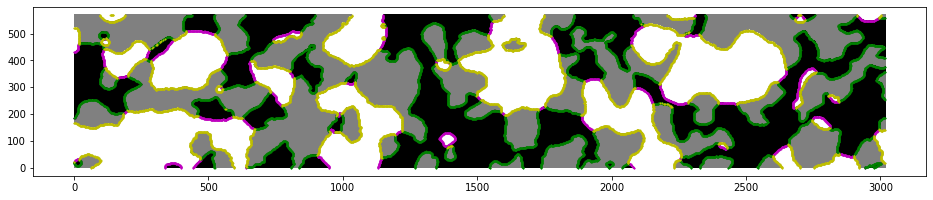

In [39]:
# initialize graph for color-separated boundaries
tphase, axx = plt.subplots(figsize=(16,6))
axx.imshow(layerone, cmap=plt.cm.gray)

# plot every point, with color depending on boundary type
y,x = zip(*bwu)
plt.scatter(x, y, c='m',s=0.8)
y,x = zip(*bgu)
plt.scatter(x, y, c='g',s=0.8)
y,x = zip(*wgu)
plt.scatter(x, y, c='y',s=0.8)

# set up graph aesthetics
axx.axis('image')
axx.invert_yaxis()
plt.show()

In [ ]:
redtree = spatial.KDTree(redlines)
bluetree = spatial.KDTree(bluelines)
yellowtree = spatial.KDTree(yellowlines)
x = redtree.query(bluelines)